In [26]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.optimize import fsolve
from tbcontrol.symbolic import routh
import pandas as pd
from time import time as millis

# IMPORTANDO DADOS

In [27]:
path = '../DataBase.csv'
df = pd.read_csv(path)
df.head()

,time,analog
0,0.03,21557
1,0.06,21547
2,0.09,21530
3,0.12,21527
4,0.15,21513


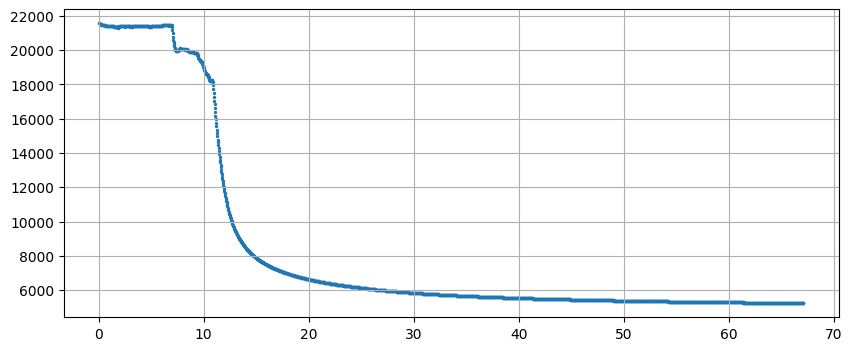

In [28]:
plt.figure(figsize=(10, 4))
plt.scatter(df.time, df.analog, s=2)
plt.grid()

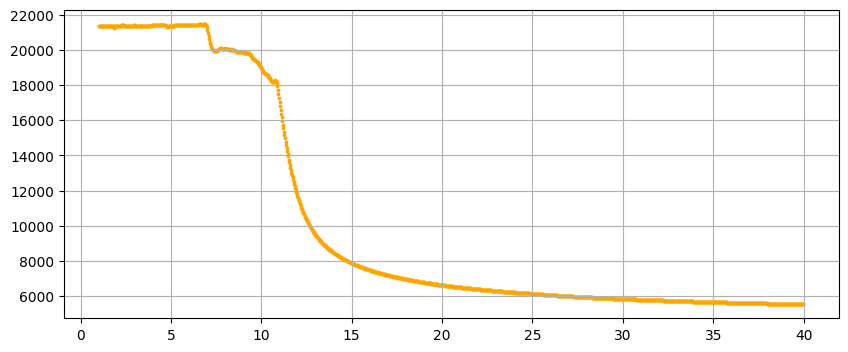

In [29]:
df = df.loc[(df.time > 1) & (df.time < 40)].reset_index(drop=True)

plt.figure(figsize=(10, 4))
plt.scatter(df.time, df.analog, s=3, color='orange')
plt.grid()

# NORMALIZANDO DADOS

In [30]:
T = 0.050

In [31]:
def normalizeData(df, timeKey, responseKey, T=0.15):
    initTime  = df[timeKey].iloc[0]
    finalTime = df[timeKey].iloc[-1] + T
    timeData  = np.arange(initTime, finalTime, T)
    
    lastValue = df[responseKey].iloc[0]
    desired = []

    for t in timeData:
        filtered = df.loc[df[timeKey] <= t][responseKey]
        
        if not filtered.empty:
            lastValue = filtered.iloc[-1]
        
        desired.append(lastValue)
    
    return timeData, desired


def normalizeTable(df, key, T=0.15):
    table = {key: []}

    for column in df.columns:
        if column == key:
            continue

        xData, yData = normalizeData(df, key, column, T)
        table[column] = yData

    table[key] = xData
    return pd.DataFrame(table) 


df['time'] = df.time - df.time[0]
df = normalizeTable(df, 'time', T)
df

,time,analog
0,0.00,21387
1,0.05,21388
2,0.10,21384
3,0.15,21380
4,0.20,21379
...,...,...
776,38.80,5542
777,38.85,5541
778,38.90,5539
779,38.95,5538


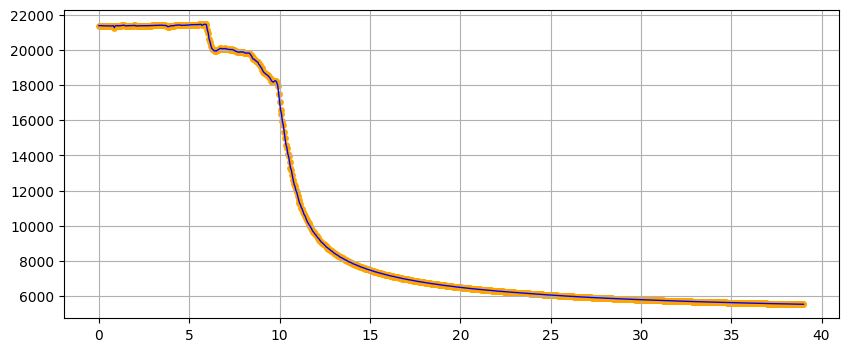

In [32]:
xData, yData = df.time.values, df.analog.values

plt.figure(figsize=(10, 4))
plt.scatter(xData, yData, s=15, color='orange')
plt.plot(xData, yData, linewidth=1, color='blue')
plt.grid()

# ANÁLISE EM FREQUÊNCIA

**DOMÍNIO DA FREQUÊNCIA** $\Rightarrow$ Fazendo a transformada de Fourier para obter os dados no domínio da frequência, onde o eixo horizontal indica a frequência e o eixo vertical indica a amplitude, geralmente as amplitudes maiores são os alvos desejados, perto de frequências baixas

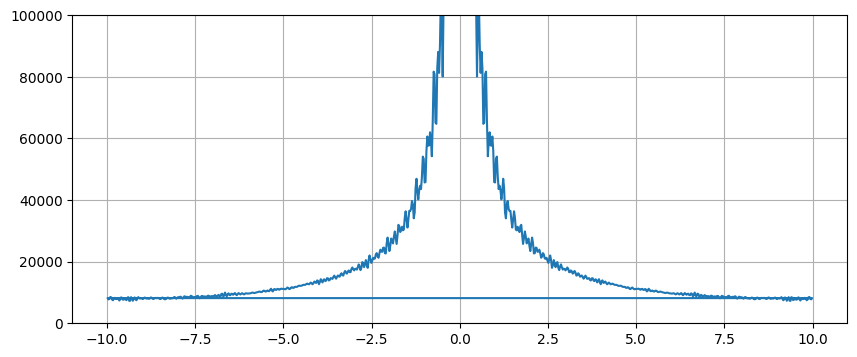

In [33]:
magnitude = np.fft.fft(yData)
frequency = np.fft.fftfreq(len(yData), T)

plt.figure(figsize=(10, 4))
plt.plot(frequency, np.abs(magnitude))
plt.ylim(0, 100000)
plt.grid()

**FILTRO PASSA BAIXA** $\Rightarrow$ O gráfico acima apresenta ruído depois da frequência principal do sistema, o objetivo é eliminar o ruído e impedir com que essas frequências sejam interpretadas

- Isso é feito escolhendo uma frequência de corte, em que tudo que está acima dessa frequência é bloqueado

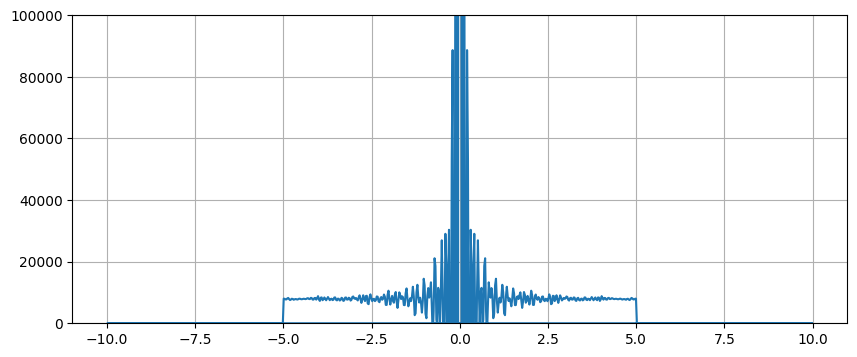

In [34]:
f_c = 5

def lowPass(frequencyArray, magnitudeArray, upperLimit):
    allowed = np.abs(frequencyArray) <= upperLimit
    magnitudeArray[~allowed] = 0
    return magnitudeArray


magnitude  = lowPass(frequency, magnitude, f_c)
plt.figure(figsize=(10, 4))
plt.plot(frequency, magnitude.real)
plt.ylim(0, 100000)
plt.grid()

- Voltando para o domínio do tempo

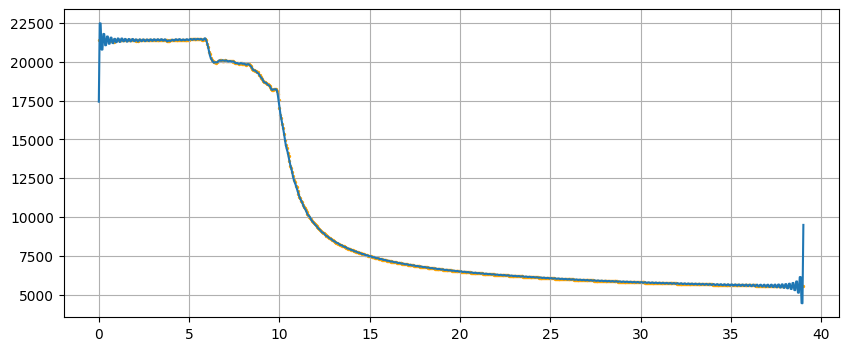

In [35]:
yData = np.fft.ifft(magnitude).real

plt.figure(figsize=(10, 4))
plt.plot(xData, yData)
plt.scatter(df.time, df.analog, s=2, color='orange')
plt.grid()

# FILTRO DE FREQUÊNCIA
A função de transferência do filtro de segunda ordem tem cara: 

- $C(s) = \frac{\omega_n^2}{s^2 + 2\zeta\omega_n s + \omega_n^2}$ $\,\,\,\,\,\,\,\,\,$ onde $\omega_n$ é a frequência natural (ou frequência de corte) do filtro em rad/s.$

- Sabemos que para atenuação ideal, $|C|_{s \to j\omega_c} = \frac{1}{\sqrt{2}} = 0.707 = \zeta$

- Usando a frequência de corte $f_c = 0.1\,\text{Hz}$
- Com isso temos a frequência natural $\omega_c = 2\pi f_c$

In [36]:
w_c = 2*np.pi*f_c
f_c, w_c

(5, 31.41592653589793)

In [37]:
s = ctl.TransferFunction.s
w_n  = w_c
zeta = 0.7071067811865475

C = w_n**2 / (s**2 + 2*zeta*w_n*s + w_n**2)
C

TransferFunction(array([986.96044011]), array([  1.        ,  44.42882938, 986.96044011]))

**COMPARAÇÃO COM O FILTRO PADRÃO** $\Rightarrow$ Vamos comparar o filtro perfeito, construído em numpy, com o filtro feito pela função de transferência, os dois devem ser aproximadamente iguais

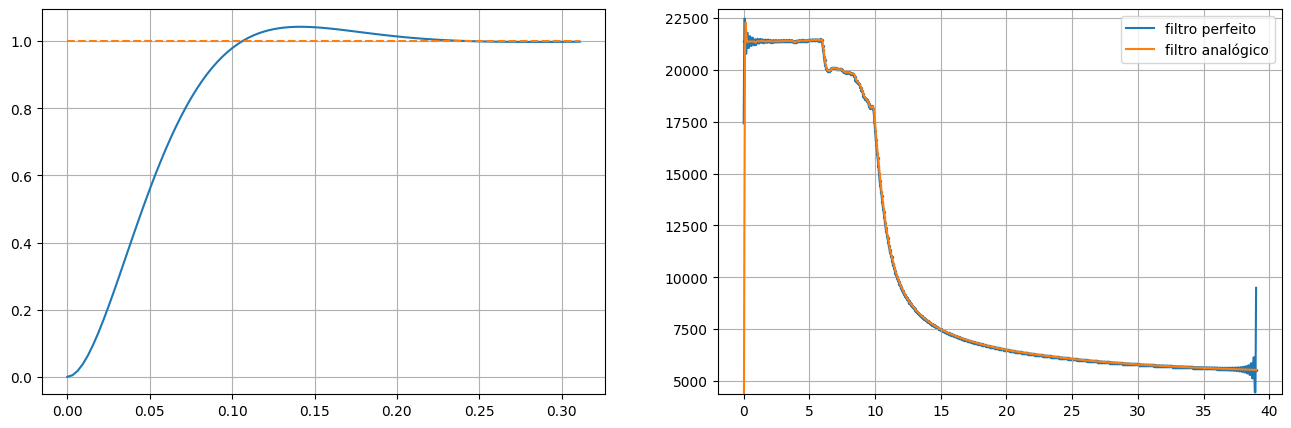

In [38]:
time, response = ctl.step_response(C)
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.plot(time, [1 for i in time], '--')
plt.grid()

xTest, yTest  = df.time.values, df.analog.values
timeArray     = np.linspace(xTest[0], xTest[-1], len(xTest))
time, reponse = ctl.forced_response(C, T=timeArray, U=yTest)

plt.subplot(1, 2, 2)
plt.plot(xData, yData, label='filtro perfeito')
plt.plot(time, reponse, label='filtro analógico')
plt.scatter(df.time, df.analog, s=2)

plt.ylim(min(yData)*0.98, max(yData)*1.02)
plt.legend()
plt.grid()

**TESTE GRÁFICO** $\Rightarrow$ O gráfico abaixo mostra que quando a frequência se aproxima da frequência $\omega_{desired}$, ocorre a atenuação

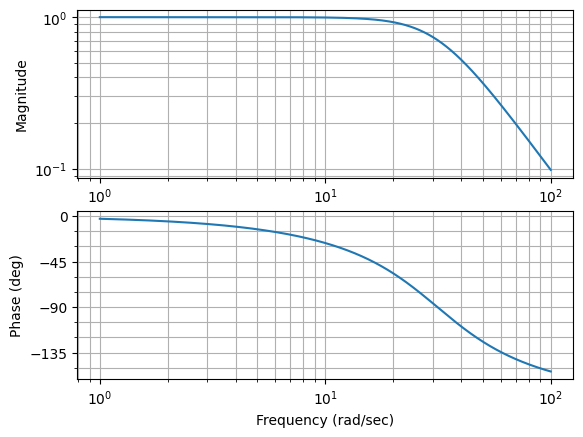

In [39]:
mag, fase, omega = ctl.bode(C, plot=True)

**TESTE NUMÉRICO** $\Rightarrow$ Vamos através dos vetores de magnitude e fase ver qual é a frequência onde ocorre a atenuação, obtendo a linha da tabela com a menor diferença entre o $\omega_{desired}$ que encontramos, e o $\omega$ da tabela. Vemos que nessa linha, a magnitude foi atenuada para um valor bem baixo
- A magnitude no ponto de frequência de corte deve ser igual a $\frac{1}{\sqrt{2}} = 0.707$ para a devida atenuação, vamos ver se isso realmente ocorre em $|C|_{s \to j\omega_c}$

In [40]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=10):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

1/np.sqrt(2)

0.7071067811865475

In [41]:
mag = sympyFunction(C).subs(s, sp.I*w_c)
mag = sp.N(sp.Abs(mag))
float(mag)

0.7071067811865477

# FILTRO DIGITAL

In [42]:
C

TransferFunction(array([986.96044011]), array([  1.        ,  44.42882938, 986.96044011]))

In [43]:
s = ctl.TransferFunction.s
C_z = ctl.c2d(C, T, method='zoh')
C_z

TransferFunction(array([0.55869771, 0.25730701]), array([ 1.        , -0.29244794,  0.10845266]), 0.05)

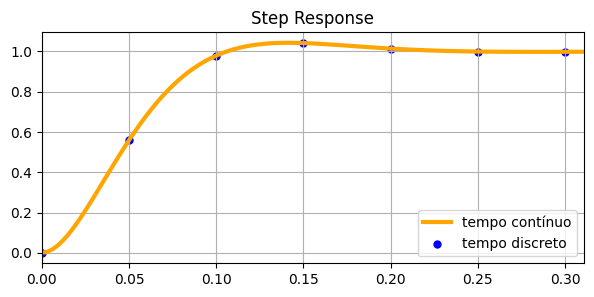

In [44]:
plt.figure(figsize=(7, 3))
time, response = ctl.step_response(C)

plt.plot(time, response, color='orange', linewidth=3, label='tempo contínuo')
plt.xlim(min(time), max(time))

time, response = ctl.step_response(C_z)
plt.scatter(time, response, color='blue', s=25, label='tempo discreto')

plt.title('Step Response')
plt.legend()
plt.grid()

In [45]:
def getDigitalFraction(C_z):
    num, den = ctl.tfdata(C_z)
    num = np.squeeze(num)
    den = np.squeeze(den)

    num = num/den[0]
    den = den/den[0]

    if type(num) == np.float64:
        num = np.array([num])

    return list(num), list(den)


num, den = getDigitalFraction(C_z)
num, den

([0.5586977077844381, 0.2573070123826987],
 [1.0, -0.2924479447673368, 0.10845266493447336])

In [46]:
def getDigitalFunction(num, den):
    out = ''
    for i in range(0, len(num)): out += f'{num[i]}*X_n{i} + '
    for i in range(1, len(den)): out += f'+ {-1*den[i]}*Y_n{i}'
    return out.replace('X_n0', 'X_n').replace('+ +', '+').replace('+ -', '-')


out = getDigitalFunction(num, den)
print(out + ';')

0.5586977077844381*X_n + 0.2573070123826987*X_n1 + 0.2924479447673368*Y_n1-0.10845266493447336*Y_n2;


In [47]:
def getDigitalFunction(C_z):
    num, den = getDigitalFraction(C_z)
    out = ''
    
    for i in range(0, len(num)): 
        out += f'X_n{i}*({num[i]:.6f}) + '

    for i in range(1, len(den)): 
        out += f'Y_n{i}*({-1*den[i]:.6f}) + '
    
    return out.replace('X_n0', 'X_n')[:-3]


out = getDigitalFunction(C_z)
print(out + ';')

X_n*(0.558698) + X_n1*(0.257307) + Y_n1*(0.292448) + Y_n2*(-0.108453);


- Criando a função no "estilo" C++ para confirmar se a máquina consegue implementar

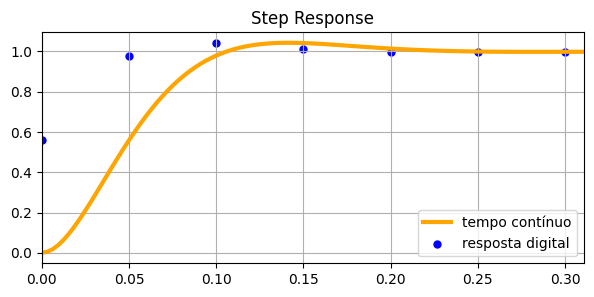

In [48]:
Y_n1 = Y_n2 = 0
X_n1 = X_n1 = 0

def compute(X_n):
    global X_n1, X_n2
    global Y_n1, Y_n2
    Y_n = eval(out)

    X_n2 = X_n1
    X_n1 = X_n

    Y_n2 = Y_n1
    Y_n1 = Y_n
    return Y_n


plt.figure(figsize=(7, 3))
time, response = ctl.step_response(C)
plt.plot(time, response, color='orange', linewidth=3, label='tempo contínuo')
plt.xlim(min(time), max(time))

time     = np.arange(0, 20, T)
response = [compute(1) for i in time] 
plt.scatter(time, response, color='blue', s=25, label='resposta digital')

plt.title('Step Response')
plt.grid()
plt.legend()
plt.show()

- Comparando o filtro digital com o filtro perfeito

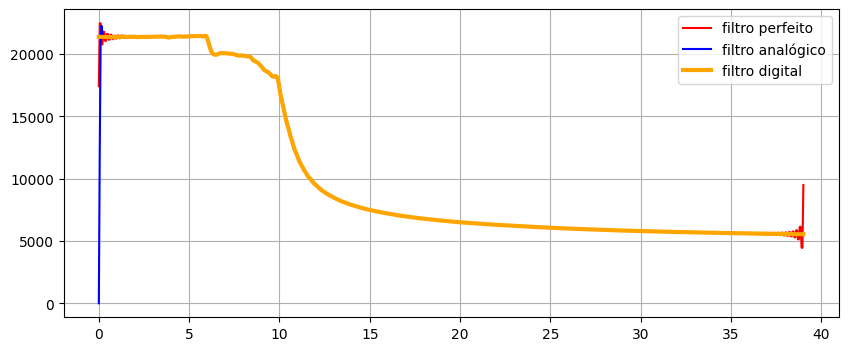

In [49]:
xTest, yTest  = df.time.values, df.analog.values
timeArray     = np.linspace(xTest[0], xTest[-1], len(xTest))
time, reponse = ctl.forced_response(C, T=timeArray, U=yTest)
for i in range(100): compute(yTest[0]) # RECALIBRANDO

plt.figure(figsize=(10, 4))
plt.plot(xData, yData, label='filtro perfeito', color='red')
plt.plot(time, reponse, label='filtro analógico', color='blue')
plt.plot(xTest, [compute(y) for y in yTest], label='filtro digital', color='orange', linewidth=3)
plt.legend()
plt.grid()

# COMPARAÇÃO GERAL DOS DADOS

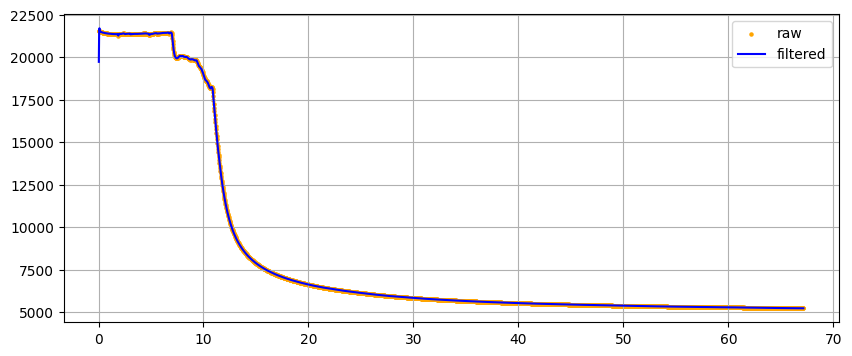

In [50]:
df = pd.read_csv(path) # voltando a base de dados original
for i in range(100): compute(yData[0]) # RECALIBRANDO

plt.figure(figsize=(10, 4))
plt.scatter(df.time, df.analog, color='orange', s=5, label='raw')
plt.plot(df.time, [compute(y) for y in df.analog], color='blue', label='filtered')

plt.grid()
plt.legend()